# Phytoplankton nutrient limitation
<div>
<img src="https://img.pagecloud.com/5v7MdnqDGKaeDDpybk5xJIM7kkQ=/552x0/filters:no_upscale()/scientific-illustrations-by-kristen/images/centric_diatom-a7dae-j39bc.png" width="300"/>
</div>

A centric diatom, another type of phytoplankton. Art credit: [Kristen Krumhardt](https://www.earthaliveillos.com/)

---

## Overview
In previous notebooks, we explored the distribution of different nutrients in the ocean. Here we examine how the growth of phytoplankton communities is limited by these nutrient distributions.

1. General setup
2. Subsetting
4. Processing data
5. Mapping nutrient limitation at the surface
6. Mapping biomass-weighted nutrient limitation in the top 100m
7. Making monthly climatology maps
   

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook/README.html) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | |

- **Time to learn**: 30 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster
import s3fs
import netCDF4

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [5]:
jetstream_url = 'https://js2.jetstream-cloud.org:8001/'

s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(endpoint_url=jetstream_url))

# Generate a list of all files in CESM folder
s3path = 's3://pythia/ocean-bgc/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1/*'
remote_files = s3.glob(s3path)

# Open all files from folder
fileset = [s3.open(file) for file in remote_files]

# Open with xarray
ds = xr.open_mfdataset(fileset, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)

ds

<xarray.Dataset> Size: 28GB
Dimensions:                         (nlat: 384, nlon: 320, time: 120, z_t: 60,
                                     z_t_150m: 15)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                            (time) object 960B 2010-01-16 12:00:00 .....
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/45)
    FG_CO2                          (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    Fe                              (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    NO3                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    PO4                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    POC_FLUX_100m                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    SALT                            (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>

## Subsetting

In [6]:
variables =['sp_Fe_lim_Cweight_avg_100m','sp_P_lim_Cweight_avg_100m','sp_N_lim_Cweight_avg_100m',
             'diat_Fe_lim_Cweight_avg_100m', 'diat_P_lim_Cweight_avg_100m','diat_N_lim_Cweight_avg_100m',
             'diat_SiO3_lim_Cweight_avg_100m','diaz_P_lim_Cweight_avg_100m',
             'diaz_Fe_lim_Cweight_avg_100m','cocco_Fe_lim_Cweight_avg_100m','cocco_C_lim_Cweight_avg_100m','cocco_N_lim_Cweight_avg_100m',
             'cocco_P_lim_Cweight_avg_100m','sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf',
             'diaz_P_lim_surf','cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','diaz_Fe_lim_surf']
keep_vars=['z_t','z_t_150m','dz','time_bound', 'time', 'TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Processing

### Global mean in time

Pull in the functions we defined in the nutrients notebook...

In [7]:
def year_mean(ds):
    """
    Properly convert monthly data to annual means, taking into account month lengths.
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")
    

Take the long-term mean of our data set. We process monthly to annual with our custom function, then use xarray's built-in `.mean()` function to process from annual data to a single mean over time, since each year is the same length.

In [8]:
ds_year = year_mean(ds).mean("year")

## Mapping nutrient limitation at the surface
Phytoplankton need a specific ratio of nutrients to grow and produce organic matter. In general, this is known as the Redfield ratio, first proposed by [Redfield et al., 1963](https://books.google.com/books?id=LeMvduUHtxQC&pg=PA26&source=gbs_toc_r&cad=1#v=onepage&q&f=false), and is approximately 106 C:16 N:1 P. Micronutrients like silicate and iron are also needed in more variable amounts depending on plankton type. To learn more about nutrient limitation, see [Sarmiento and Gruber Chapter 4: Organic Matter Production](https://doi.org/10.2307/j.ctt3fgxqx.7).
Our dataset uses a numerical notation to specify which nutrient is limiting in each area for each phytoplankton functional type, as specified below:
- 0 = PO4
- 1 = Fe
- 2 = NO3 (only for small phytoplankton and diatoms)
- 3 = Si (only for diatoms)
- 3 = C (only for coccolithophores)
  
To turn this information into a single array, we concatenate the limitation terms along the `nutrient` dimension for each phytoplankton functional type.

In [9]:
limarray_sp=xr.concat((ds_year.sp_P_lim_surf, ds_year.sp_Fe_lim_surf,ds_year.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((ds_year.diat_P_lim_surf, ds_year.diat_Fe_lim_surf, ds_year.diat_N_lim_surf, ds_year.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((ds_year.diaz_P_lim_surf, ds_year.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((ds_year.cocco_P_lim_surf, ds_year.cocco_Fe_lim_surf, ds_year.cocco_N_lim_surf, ds_year.cocco_C_lim_surf),dim='nutrient')
                          
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()
mask = np.isnan(ds_year.sp_N_lim_surf.squeeze())

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 25.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 15.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 25.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 15.07 Mi

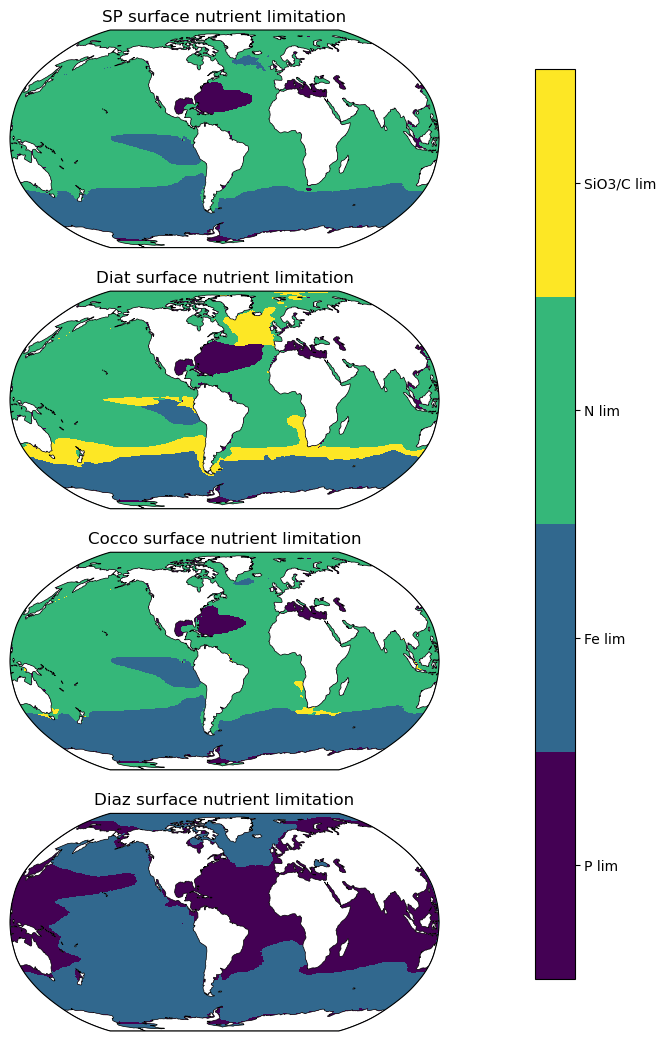

In [10]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat surface nutrient limitation', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diat.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP surface nutrient limitation', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_sp.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco surface nutrient limitation', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_cocco.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz surface nutrient limitation', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diaz.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

## Mapping biomass-weighted nutrient limitation in the top 100m

In [11]:
limarray_sp=xr.concat((ds_year.sp_P_lim_Cweight_avg_100m, ds_year.sp_Fe_lim_Cweight_avg_100m,ds_year.sp_N_lim_Cweight_avg_100m),dim='nutrient')
limarray_diat=xr.concat((ds_year.diat_P_lim_Cweight_avg_100m, ds_year.diat_Fe_lim_Cweight_avg_100m, ds_year.diat_N_lim_Cweight_avg_100m, ds_year.diat_SiO3_lim_Cweight_avg_100m),dim='nutrient')
limarray_diaz=xr.concat((ds_year.diaz_P_lim_Cweight_avg_100m, ds_year.diaz_Fe_lim_Cweight_avg_100m),dim='nutrient')
limarray_cocco=xr.concat((ds_year.cocco_P_lim_Cweight_avg_100m, ds_year.cocco_Fe_lim_Cweight_avg_100m, ds_year.cocco_N_lim_Cweight_avg_100m, ds_year.cocco_C_lim_Cweight_avg_100m),dim='nutrient')
                          
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()
mask = np.isnan(ds_year.sp_N_lim_surf.squeeze())

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 25.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 20.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 25.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 15.07 Mi

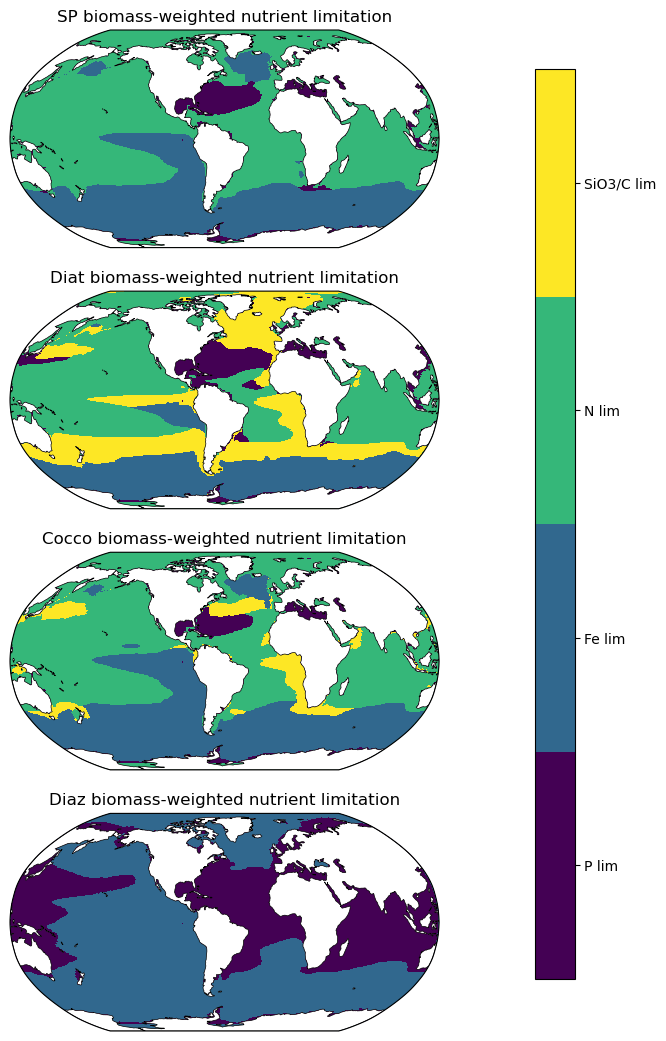

In [12]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat biomass-weighted nutrient limitation', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diat.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP biomass-weighted nutrient limitation', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_sp.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco biomass-weighted nutrient limitation', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_cocco.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz biomass-weighted nutrient limitation', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diaz.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

## Making monthly climatology maps

### Make a monthly climatology dataset
A monthly climatology is a dataset where data from each month, including over different years, is averaged together. So for our dataset, the groups would include the average of all Januaries 2010-2019, all Februaries 2010-2019, and so on. This would usually be over a longer time period such as 30 or more years, but we use our shorter dataset so that it processes faster. This technique is helpful for looking at seasonal phenomena while averaging out year-to-year fluctuations.

In [16]:
mon_ds = ds.copy()
mon_ds = ds.groupby('time.month').mean('time')

In [17]:
limarray_sp=xr.concat((mon_ds.sp_P_lim_surf, mon_ds.sp_Fe_lim_surf,mon_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((mon_ds.diat_P_lim_surf, mon_ds.diat_Fe_lim_surf, mon_ds.diat_N_lim_surf, mon_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((mon_ds.diaz_P_lim_surf, mon_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((mon_ds.cocco_P_lim_surf, mon_ds.cocco_Fe_lim_surf, mon_ds.cocco_N_lim_surf, mon_ds.cocco_C_lim_surf),dim='nutrient')

most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(ds_year.sp_N_lim_surf.squeeze())

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 25.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 15.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 25.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 25.05 Mi

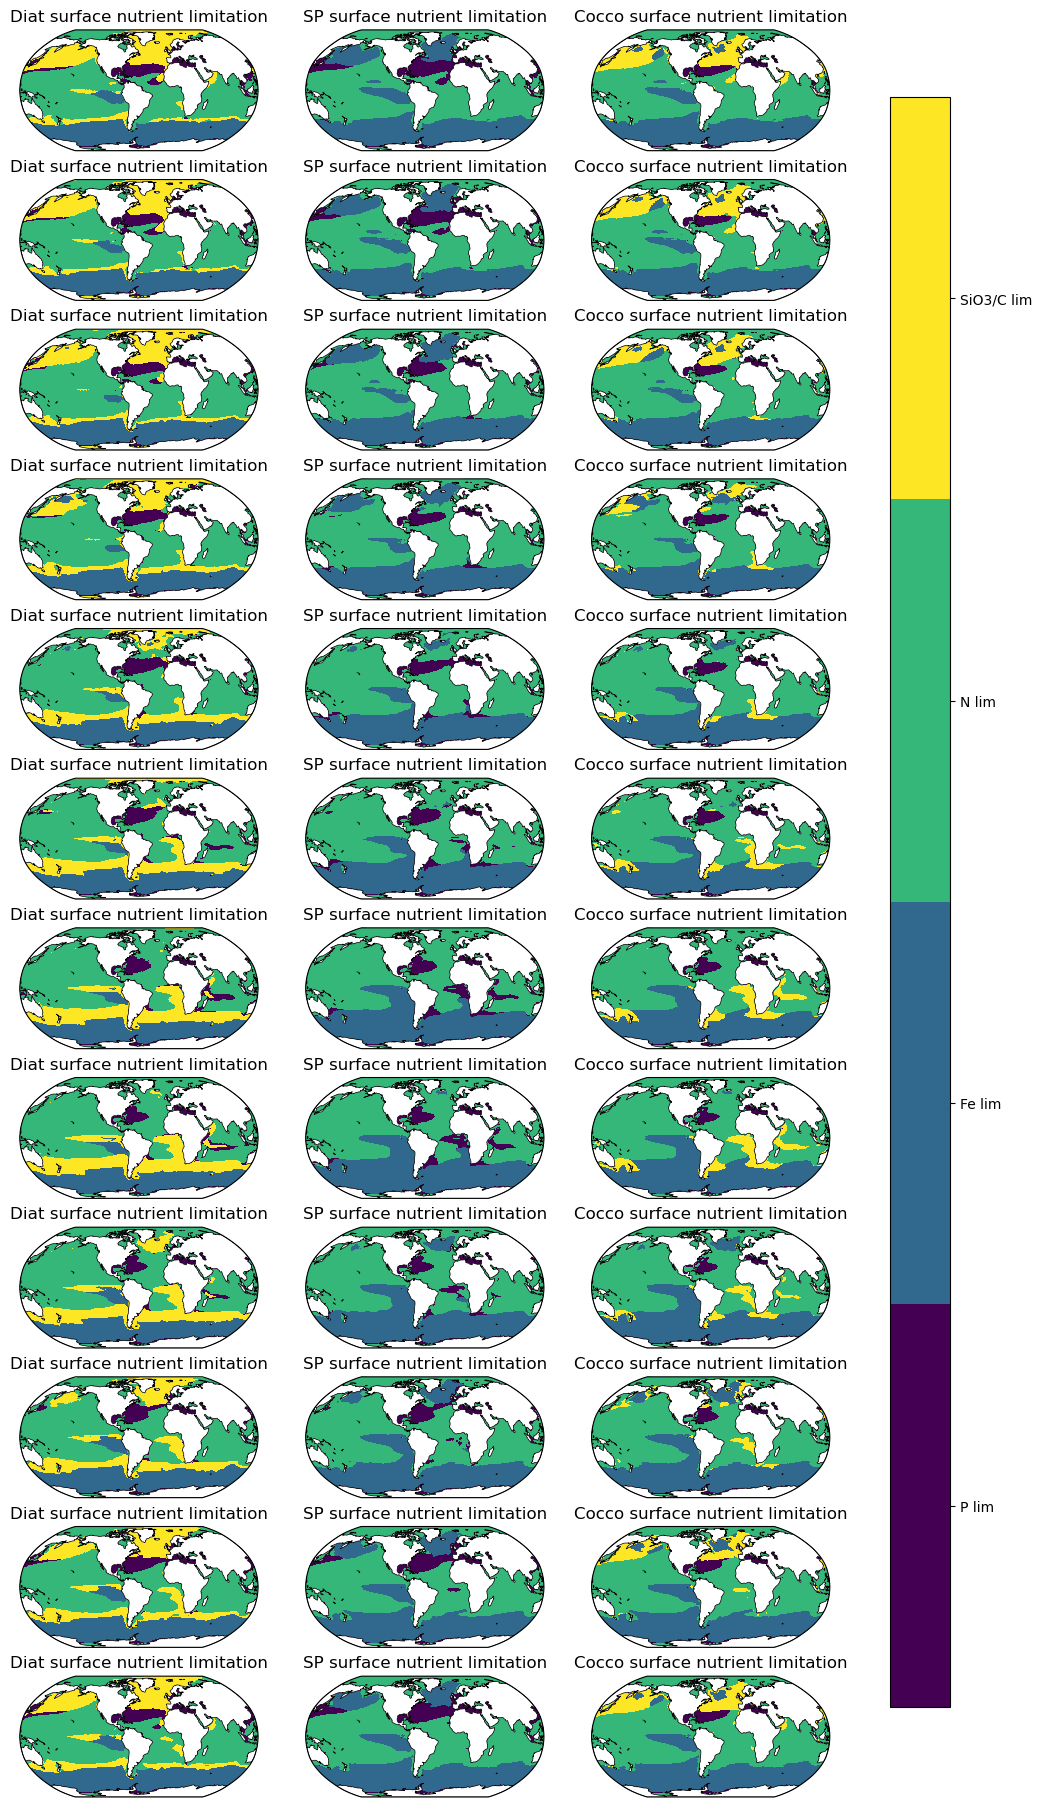

In [18]:
fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    #row 1 Jan
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diat surface nutrient limitation', fontsize=12)
    lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_diat.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SP surface nutrient limitation', fontsize=12)
    lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_sp.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Cocco surface nutrient limitation', fontsize=12)
    lon, lat, field = adjust_pop_grid(lons, lats,  most_lim_cocco.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=matplotlib.colormaps['viridis'].resampled(4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

And close the Dask cluster we spun up at the beginning.

In [19]:
cluster.close()

---

## Summary
You've learned how to evaluate phytoplankton nutrient limitation.

## Resources and references
- [Sarmiento and Gruber Chapter 4: Organic Matter Production](https://doi.org/10.2307/j.ctt3fgxqx.7) (see Limiting Nutrient in Section 4.2)
- [Redfield et al., 1963](https://books.google.com/books?id=LeMvduUHtxQC&pg=PA26&source=gbs_toc_r&cad=1#v=onepage&q&f=false)